In [1]:
import pandas as pd
import os
from pathlib import Path
from typing import Union, List

def load_crypto_data(
    base_path: Union[str, Path],
    symbol: str = "BTCUSDT",
    year: str = "2024",
    freq: str = "1m"
) -> pd.DataFrame:
    """
    加載並合併特定交易對的所有每日CSV文件
    
    Args:
        base_path (str/Path): 數據文件的基礎路徑
        symbol (str): 交易對名稱，如 "BTCUSDT"
        year (str): 年份，如 "2022"
        freq (str): 頻率，如 "1m"
    
    Returns:
        pd.DataFrame: 合併後的DataFrame
    """
    # 確保base_path是Path對象
    base_path = Path(base_path)
    
    # 構建文件匹配模式
    pattern = f"{symbol}_{year}-*_{freq}.csv"
    
    # 獲取所有匹配的文件並排序
    csv_files = sorted(list(base_path.glob(pattern)))
    
    if not csv_files:
        raise ValueError(f"No files found matching pattern: {pattern}")
    
    # 讀取並合併所有CSV文件
    dfs = []
    for file in csv_files:
        try:
            df = pd.read_csv(file)
            dfs.append(df)
        except Exception as e:
            print(f"Error reading file {file}: {e}")
    
    # 合併所有DataFrame
    if not dfs:
        raise ValueError("No data was successfully loaded")
    
    merged_df = pd.concat(dfs, ignore_index=True)
    
    # 確保時間列正確格式化
    merged_df['open_time'] = pd.to_datetime(merged_df['open_time'])
    merged_df['close_time'] = pd.to_datetime(merged_df['close_time'])
    
    # 按時間排序
    merged_df = merged_df.sort_values('open_time').reset_index(drop=True)
    
    # 檢查並移除重複數據
    merged_df = merged_df.drop_duplicates(subset=['open_time'], keep='first')
    
    return merged_df

def check_data_quality(df: pd.DataFrame) -> dict:
    """
    檢查合併後數據的質量
    
    Args:
        df (pd.DataFrame): 待檢查的DataFrame
    
    Returns:
        dict: 包含各種數據質量指標的字典
    """
    quality_report = {
        'total_rows': len(df),
        'date_range': (df['open_time'].min(), df['open_time'].max()),
        'missing_values': df.isnull().sum().to_dict(),
        'duplicate_times': len(df) - len(df['open_time'].unique()),
    }
    
    # 檢查時間間隔
    time_diffs = df['open_time'].diff().value_counts()
    quality_report['time_intervals'] = time_diffs
    
    return quality_report

# 使用示例


In [2]:

# 假設數據路徑
data_path = "/Users/mouyasushi/Desktop/quantDevops/Backtest_Performance/Alpha-Research/kline/binance/BTCUSDT/1m"

# 加載數據
btc_data = load_crypto_data(
    base_path=data_path,
    symbol="BTCUSDT",
    year="2024",
    freq="1m"
)

# 檢查數據質量
quality_report = check_data_quality(btc_data)

# 輸出基本信息
print(f"Loaded data shape: {btc_data.shape}")
print(f"Date range: {quality_report['date_range']}")
print(f"Total rows: {quality_report['total_rows']}")

Loaded data shape: (488160, 12)
Date range: (Timestamp('2024-01-01 00:00:00'), Timestamp('2024-12-04 23:59:00'))
Total rows: 488160


In [3]:
btc_data = btc_data.set_index('open_time')

In [4]:
btc_data

,open,high,low,close,volume,close_time,quote_asset_volume,number_of_trades,taker_buy_base_asset_volume,taker_buy_quote_asset_volume,ignore
open_time,,,,,,,,,,,
2024-01-01 00:00:00,42314.0,42335.8,42289.6,42331.9,289.641,2024-01-01 00:00:59.999,1.225616e+07,3310,175.211,7.414460e+06,0
2024-01-01 00:01:00,42331.9,42353.1,42331.8,42350.4,202.444,2024-01-01 00:01:59.999,8.572241e+06,1885,154.353,6.535805e+06,0
2024-01-01 00:02:00,42350.4,42370.8,42349.6,42360.2,271.521,2024-01-01 00:02:59.999,1.150139e+07,2143,193.034,8.176843e+06,0
2024-01-01 00:03:00,42360.1,42405.8,42360.1,42405.8,392.238,2024-01-01 00:03:59.999,1.662644e+07,3551,332.749,1.410472e+07,0
2024-01-01 00:04:00,42405.7,42437.2,42405.7,42437.1,568.366,2024-01-01 00:04:59.999,2.411261e+07,4479,419.524,1.779786e+07,0
...,...,...,...,...,...,...,...,...,...,...,...
2024-12-04 23:55:00,98803.5,98835.0,98775.7,98786.1,70.970,2024-12-04 23:55:59.999,7.012476e+06,1567,35.110,3.469313e+06,0
2024-12-04 23:56:00,98786.1,98792.9,98734.6,98770.7,151.892,2024-12-04 23:56:59.999,1.499998e+07,2414,51.604,5.096036e+06,0
2024-12-04 23:57:00,98770.7,98778.0,98740.1,98769.9,73.575,2024-12-04 23:57:59.999,7.265887e+06,1396,19.852,1.960477e+06,0


strat 

In [5]:
import numpy as np 

def calculate_vwap(df):
    """
    计算VWAP指标，每日重置
    """
    # 设置时间索引
    df = df.copy()
    
    # 添加日期列用于分组
    df['date'] = df.index.date
    df['minute'] = df.index.time
    
    # 计算典型价格
    df['typical_price'] = (df['high'].shift(1) + df['low'].shift(1) + df['close'].shift(1)) / 3
    
    # 计算累积值（按日期分组）
    df['cum_tp_vol'] = df.groupby('date')['typical_price'].transform(lambda x: x * df['volume'].shift(1))
    df['cum_vol'] = df.groupby('date')['volume'].transform(lambda x: x.shift(1))
    
    # 计算日内累积VWAP
    df['cum_vwap'] = df.groupby('date').apply(
        lambda x: x['cum_tp_vol'].cumsum() / x['cum_vol'].cumsum()
    ).values
    
    # 计算5分钟滚动VWAP（每日重置）
    df['rolling_tp_vol'] = df.groupby('date')['cum_tp_vol'].transform(
        lambda x: x.rolling(window=5, min_periods=1).sum()
    )
    df['rolling_vol'] = df.groupby('date')['cum_vol'].transform(
        lambda x: x.rolling(window=5, min_periods=1).sum()
    )
    df['rolling_vwap'] = df['rolling_tp_vol'] / df['rolling_vol']
    
    return df



In [6]:
df = calculate_vwap(btc_data)

/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_98525/3280192461.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cum_vwap'] = df.groupby('date').apply(


In [7]:


def generate_signals(df):
    """
    生成交易信号，考虑交易时间限制
    """
    df = df.copy()
    
    # 修改交易时间掩码的创建方式
    # 方法1：使用 reset_index 处理 groupby 结果
    trading_mask = df.groupby('date').apply(
        lambda x: pd.Series(x.index.time > pd.Timestamp('00:30:00').time(), index=x.index)
    ).reset_index(level=0, drop=True)
    
    # 基于累积VWAP的信号
    df['cum_signal'] = 0
    df.loc[df['close'].shift(1) > df['cum_vwap'], 'cum_signal'] = 1
    df.loc[df['close'].shift(1) < df['cum_vwap'], 'cum_signal'] = -1
    
    # 交易信号（仅在穿越时）
    df['trade_signal'] = df['cum_signal'].diff()
    
    # 使用5分钟VWAP作为过滤器
    df['filtered_signal'] = df['trade_signal'].copy()
    df.loc[(df['close'].shift(1) < df['rolling_vwap']) & (df['trade_signal'] == 1), 'filtered_signal'] = 0
    df.loc[(df['close'].shift(1) > df['rolling_vwap']) & (df['trade_signal'] == -1), 'filtered_signal'] = 0
    
    # 应用交易时间限制
    df.loc[~trading_mask, ['trade_signal', 'filtered_signal']] = 0
    
    # 添加双VWAP突破信号
    df['double_break'] = 0
    df.loc[(df['close'].shift(1) > df['rolling_vwap']) & 
           (df['close'].shift(1) > df['cum_vwap']), 'double_break'] = 1
    df.loc[(df['close'].shift(1) < df['rolling_vwap']) & 
           (df['close'].shift(1) < df['cum_vwap']), 'double_break'] = -1
    
    return df

In [8]:
def backtest(df, signal_column, initial_capital=10000):
    """
    执行回测，包含仓位管理
    """
    position = 0
    capital = initial_capital
    trades = []
    base_position = 100  # 基础仓位
    
    for i in range(1, len(df)):
        signal = df[signal_column].iloc[i]
        current_price = df['close'].iloc[i]
        current_time = df.index[i]
        double_break = df['double_break'].iloc[i]
        
        # 多信号
        if signal == 2 and position < 200:  # 限制最大仓位
            # 如果有空仓，先平仓
            if position < 0:
                profit = (df['close'].iloc[i-1] - current_price) * abs(position)
                capital += profit
                position = 0
            
            # 开多仓
            new_position = base_position
            if double_break == 1 and position == base_position:  # 双突破加仓
                new_position = base_position
            
            position += new_position
            entry_price = current_price
            trades.append({
                'time': current_time,
                'type': 'LONG',
                'price': entry_price,
                'position': position,
                'capital': capital
            })
            
        # 空信号
        elif signal == -2 and position > -200:  # 限制最大仓位
            # 如果有多仓，先平仓
            if position > 0:
                profit = (current_price - entry_price) * position
                capital += profit
                position = 0
            
            # 开空仓
            new_position = base_position
            if double_break == -1 and position == -base_position:  # 双突破加仓
                new_position = base_position
            
            position -= new_position
            entry_price = current_price
            trades.append({
                'time': current_time,
                'type': 'SHORT',
                'price': entry_price,
                'position': position,
                'capital': capital
            })
    
    return pd.DataFrame(trades)

In [9]:
def analyze_vwap_strategy(df):
    """
    分析VWAP策略表现
    """
    # 计算VWAP
    df = calculate_vwap(df)
    
    # 生成信号
    df = generate_signals(df)
    
    # 执行回测
    results_unfiltered = backtest(df, 'trade_signal')
    results_filtered = backtest(df, 'filtered_signal')
    
    # 计算统计数据
    stats = {
        'unfiltered': {
            'total_trades': len(results_unfiltered),
            'final_capital': results_unfiltered['capital'].iloc[-1] if len(results_unfiltered) > 0 else 10000,
            'return': ((results_unfiltered['capital'].iloc[-1] if len(results_unfiltered) > 0 else 10000) - 10000) / 10000 * 100
        },
        'filtered': {
            'total_trades': len(results_filtered),
            'final_capital': results_filtered['capital'].iloc[-1] if len(results_filtered) > 0 else 10000,
            'return': ((results_filtered['capital'].iloc[-1] if len(results_filtered) > 0 else 10000) - 10000) / 10000 * 100
        }
    }
    
    return df, results_unfiltered, results_filtered, stats



In [10]:
analyze_vwap_strategy(df)

/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_98525/3280192461.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cum_vwap'] = df.groupby('date').apply(
/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_98525/2968647625.py:9: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trading_mask = df.groupby('date').apply(


(                        open     high      low    close   volume  \
 open_time                                                          
 2024-01-01 00:00:00  42314.0  42335.8  42289.6  42331.9  289.641   
 2024-01-01 00:01:00  42331.9  42353.1  42331.8  42350.4  202.444   
 2024-01-01 00:02:00  42350.4  42370.8  42349.6  42360.2  271.521   
 2024-01-01 00:03:00  42360.1  42405.8  42360.1  42405.8  392.238   
 2024-01-01 00:04:00  42405.7  42437.2  42405.7  42437.1  568.366   
 ...                      ...      ...      ...      ...      ...   
 2024-12-04 23:55:00  98803.5  98835.0  98775.7  98786.1   70.970   
 2024-12-04 23:56:00  98786.1  98792.9  98734.6  98770.7  151.892   
 2024-12-04 23:57:00  98770.7  98778.0  98740.1  98769.9   73.575   
 2024-12-04 23:58:00  98769.9  98769.9  98670.3  98670.3  161.254   
 2024-12-04 23:59:00  98670.3  98700.0  98669.5  98669.8  172.461   
 
                                  close_time  quote_asset_volume  \
 open_time                       

plot 

/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_18203/3280192461.py:22: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df['cum_vwap'] = df.groupby('date').apply(
/var/folders/kz/g7fm_pz11tv5kbttdpy6thc40000gn/T/ipykernel_18203/393746288.py:12: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  trading_mask = df.groupby('date').apply(


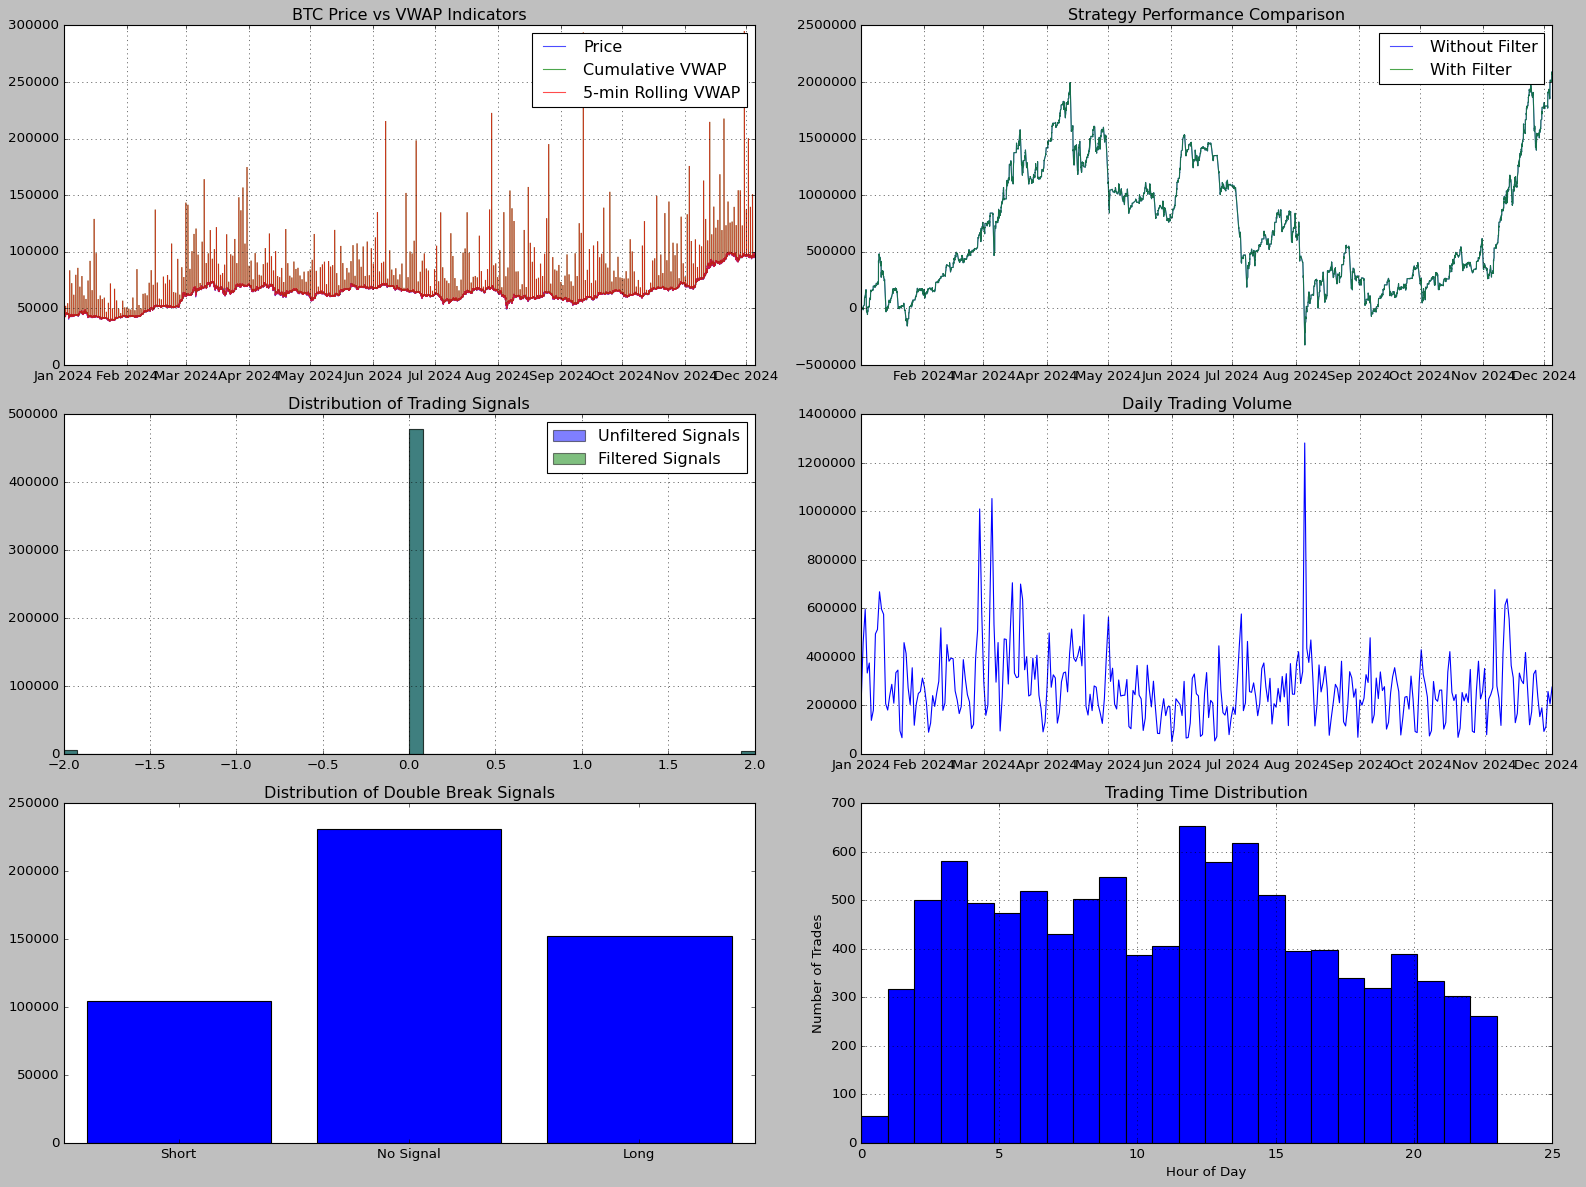


=== 策略统计结果 ===

未过滤策略：
总交易次数: 10324
最终资金: 2090560.00
收益率: 20805.60%

过滤后策略：
总交易次数: 10324
最终资金: 2090560.00
收益率: 20805.60%


In [19]:
import matplotlib.pyplot as plt 

def plot_results(df, results_unfiltered, results_filtered):
    """
    绘制策略结果的详细分析图
    """
    plt.style.use('classic')
    
    # 创建一个3x2的子图布局
    fig = plt.figure(figsize=(20, 15))
    
    # 1. 价格和VWAP走势图
    ax1 = plt.subplot(3, 2, 1)
    ax1.plot(df.index, df['close'], label='Price', alpha=0.7, linewidth=1)
    ax1.plot(df.index, df['cum_vwap'], label='Cumulative VWAP', alpha=0.7, linewidth=1)
    ax1.plot(df.index, df['rolling_vwap'], label='5-min Rolling VWAP', alpha=0.7, linewidth=1)
    ax1.set_title('BTC Price vs VWAP Indicators')
    ax1.legend()
    ax1.grid(True)
    
    # 2. 策略收益对比
    ax2 = plt.subplot(3, 2, 2)
    if len(results_unfiltered) > 0:
        ax2.plot(results_unfiltered['time'], results_unfiltered['capital'], 
                label='Without Filter', alpha=0.7)
    if len(results_filtered) > 0:
        ax2.plot(results_filtered['time'], results_filtered['capital'], 
                label='With Filter', alpha=0.7)
    ax2.set_title('Strategy Performance Comparison')
    ax2.legend()
    ax2.grid(True)
    
    # 3. 交易信号分布
    ax3 = plt.subplot(3, 2, 3)
    df['trade_signal'].hist(bins=50, alpha=0.5, label='Unfiltered Signals', ax=ax3)
    df['filtered_signal'].hist(bins=50, alpha=0.5, label='Filtered Signals', ax=ax3)
    ax3.set_title('Distribution of Trading Signals')
    ax3.legend()
    
    # 4. 每日交易量分析
    ax4 = plt.subplot(3, 2, 4)
    daily_volume = df.groupby('date')['volume'].sum()
    ax4.plot(daily_volume.index, daily_volume.values, label='Daily Volume')
    ax4.set_title('Daily Trading Volume')
    ax4.grid(True)
    
    # 5. 双突破信号分析
    ax5 = plt.subplot(3, 2, 5)
    double_break_counts = df['double_break'].value_counts()
    ax5.bar(double_break_counts.index, double_break_counts.values)
    ax5.set_title('Distribution of Double Break Signals')
    ax5.set_xticks([-1, 0, 1])
    ax5.set_xticklabels(['Short', 'No Signal', 'Long'])
    
    # 6. 交易时间分布
    ax6 = plt.subplot(3, 2, 6)
    if len(results_filtered) > 0:
        trade_hours = pd.to_datetime(results_filtered['time']).dt.hour
        trade_hours.hist(bins=24, ax=ax6)
        ax6.set_title('Trading Time Distribution')
        ax6.set_xlabel('Hour of Day')
        ax6.set_ylabel('Number of Trades')
    
    plt.tight_layout()
    plt.show()
    
    # 打印详细统计信息
    print("\n=== 策略统计结果 ===")
    print("\n未过滤策略：")
    print(f"总交易次数: {stats['unfiltered']['total_trades']}")
    print(f"最终资金: {stats['unfiltered']['final_capital']:.2f}")
    print(f"收益率: {stats['unfiltered']['return']:.2f}%")
    
    print("\n过滤后策略：")
    print(f"总交易次数: {stats['filtered']['total_trades']}")
    print(f"最终资金: {stats['filtered']['final_capital']:.2f}")
    print(f"收益率: {stats['filtered']['return']:.2f}%")

# 执行分析和绘图
df, results_unfiltered, results_filtered, stats = analyze_vwap_strategy(btc_data)
plot_results(df, results_unfiltered, results_filtered)